# 기존 모델과 nnUNet 비교

---

## train dataset (1078개)의 8:1:1로 나눈 test set

### 전처리

In [14]:
from glob import glob

mask_file_home = r"C:\Users\qwe14\0.code\nnUNet\nnUNet_raw\Dataset121_MR\labelsTs"
mask_file_path = glob(f"{mask_file_home}\\*.png")
test_origin_path = []
with open(r"C:\Users\qwe14\0.code\sarcopenia\data_train\train_annot_2\data_relation.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        rel_path, jpg_file = line.strip().split("\t")
        png_file = "C:\\Users\\qwe14\\0.code\\nnUNet\\nnUNet_raw\\Dataset121_MR\\labelsTs\\img-"+jpg_file.replace("jpg", "png")
        if png_file in mask_file_path:
            abs_path = r"C:\Users\qwe14\0.code\sarcopenia\data_train_raw\TrainingData2차_raw" + f"\\{rel_path}"
            test_origin_path.append([abs_path, jpg_file])
print(len(test_origin_path))

108


In [15]:
print(test_origin_path[0])

['C:\\Users\\qwe14\\0.code\\sarcopenia\\data_train_raw\\TrainingData2차_raw\\200307_L3_External validation_MASK\\sarc-10001', '00001.jpg']


In [18]:
import shutil

def copy_folder(src_dir, dest_dir):
    shutil.copytree(src_dir, dest_dir)

if __name__ == "__main__":
    for (src_dir, jpg_name) in test_origin_path:
        dest_dir_home = r"C:\Users\qwe14\IAID_program\test_data"
        file_num = jpg_name.split(".")[0]
        dest_dir = f"{dest_dir_home}\\{file_num}"
        copy_folder(src_dir, dest_dir)

#### 기존 모델에 위 테스트 데이터(108개)를 돌릴경우 결과가 나오지 않음
#### 그래서 다른 test set(900개)를 바탕으로 평가 예정

---

## HU 값이 적용된 test set(900개)

#### 기존 모델로 예측 결과 894개 성공
### 894개 데이터에 대한 metric 비교

In [1]:
import sys
sys.path.append('C:\\Users\\qwe14\\anaconda3\\envs\\nnunet\\lib\\site-packages')

from PIL import Image
from glob import glob
import numpy as np
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import pydicom
import os

In [34]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
def calculate_binary_metrics(pm_mask, gm_mask):
    f1_micro = f1_score(pm_mask.flatten(), gm_mask.flatten(), average='micro')
    f1_macro = f1_score(pm_mask.flatten(), gm_mask.flatten(), average='macro')
    accuracy = accuracy_score(pm_mask.flatten(), gm_mask.flatten())

    return f1_micro, f1_macro, accuracy
    
def calculate_iou(predicted_mask, ground_truth_mask):
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    if intersection == 0:
        return 0
    else:
        return 2 * intersection / (np.sum(y_true) + np.sum(y_pred))

In [46]:
def norm_img(img):
    norm_image = np.array(img, dtype=np.float64)
    norm_image -= np.min(norm_image)
    norm_image /= np.max(norm_image)
    normalized_image = norm_image * 255
    normalized_image = normalized_image.astype(np.uint8)
    return normalized_image


def get_preprocess_dcm_img(dcm):
    dcm_array = dcm.pixel_array
    try:
        hu_image = dcm_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = dcm.WindowCenter - dcm.WindowWidth // 2
        img_max = dcm.WindowCenter + dcm.WindowWidth // 2
    except AttributeError:
        hu_image = dcm_array
        img_min = 40 - 200
        img_max = 40 + 200
    except TypeError:
        img_min = dcm.WindowCenter[0] - dcm.WindowWidth[0] // 2
        img_max = dcm.WindowCenter[0] + dcm.WindowWidth[0] // 2
    hu_image[hu_image < -1024] = np.array(-1024).astype(hu_image.dtype)
    preprocessed_img = np.clip(hu_image, img_min, img_max)
    return preprocessed_img
    
def hu_mask(dcm_path, dcmimg_path, mask_path, pred_mask_path):
    output_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    try:
        output_mask_origin = output_mask.copy()
        hu_range = {
            "Sfat": [1, [-190, -30]], # Sfat
            "muscle": [2, [-190, 150]], # Muscle
            "Vfat": [3, [-190, -30]]  # Vfat
        }
        dcm = pydicom.dcmread(dcm_path)
        hu_image = get_preprocess_dcm_img(dcm)
    
        # Vfat mask postprocess
        sfat_range = hu_range["Sfat"][1]
        sfat_condition1 = (sfat_range[0] < hu_image)
        sfat_condition2 = (hu_image < sfat_range[1])
        co = sfat_condition1 & sfat_condition2
        sfat_mask = np.zeros_like(output_mask)
        sfat_mask[co.astype(bool) & (output_mask == hu_range["Sfat"][0])] = 1
        output_mask[(sfat_mask == 0) & (output_mask == hu_range["Sfat"][0])] = 0
    
        # muscle mask postprocess
        muscle_range = hu_range["muscle"][1]
        muscle_condition1 = (muscle_range[0] < hu_image)
        muscle_condition2 = (hu_image < muscle_range[1])
        co = muscle_condition1 & muscle_condition2
        muscle_mask = np.zeros_like(output_mask)
        muscle_mask[co.astype(bool) & (output_mask == hu_range["muscle"][0])] = 1
        output_mask[(muscle_mask == 0) & (output_mask == hu_range["muscle"][0])] = 0
    
        # Vfat mask postprocess
        vfat_range = hu_range["Sfat"][1]
        vfat_condition1 = (vfat_range[0] < hu_image)
        vfat_condition2 = (hu_image < vfat_range[1])
        co = vfat_condition1 & vfat_condition2
        vfat_mask = np.zeros_like(output_mask)
        vfat_mask[co.astype(bool) & (output_mask == hu_range["Vfat"][0])] = 1
        output_mask[(vfat_mask == 0) & (output_mask == hu_range["Vfat"][0])] = 0
        
        background_img = cv2.imread(dcmimg_path, cv2.IMREAD_GRAYSCALE)
        
#         plt.subplot(1,4,1)
#         plt.axis('off')
#         plt.gca().set_title('windowing Img')
#         plt.imshow(background_img, cmap = cm.gray)
        
#         plt.subplot(1,4,2)
#         plt.axis('off')
#         plt.gca().set_title('GT Mask')
#         plt.imshow(gt_mask, cmap = cm.gray)
        
#         plt.subplot(1,4,3)
#         plt.axis('off')
#         plt.gca().set_title('pred hu Mask')
#         plt.imshow(output_mask, cmap = cm.gray)

#         plt.subplot(1,4,4)
#         plt.axis('off')
#         plt.gca().set_title('pred Mask')
#         plt.imshow(output_mask_origin, cmap = cm.gray)
        
#         plt.show()
    except TypeError:
        print(f"output_mask None{mask_path}")
        return [None, None]
    except pydicom.errors.InvalidDicomError:
        print(f"pydicom.err InvalidDicomError: {dcm_path}")
        return [None, None]
    return [gt_mask, output_mask]

### mask 저장
- body_mask, muscle_mask, sfat_mask 를 하나의 마스크로 바꿔 저장
- background = 0, body = 1, muscle = 2, sfat = 3

In [15]:
# import os
# # C:\Users\qwe14\0.code\sarcopenia\data_train_raw\output\result01\L3Data\SarcopeniaCase1_20061220_DCM\Mask_Body\*.png
# link = r"C:\Users\qwe14\0.code\sarcopenia\data_train_raw\output\result01\L3Data\*\Mask_*\*.png"
# mask_path = glob(link)
# for idx, path in enumerate(mask_path):
#     if idx % 3 == 0:
#         body_mask_path = path
#     elif idx % 3 == 1:
#         muscle_mask_path = path
#     else:
#         sfat_mask_path = path
#         sfat_mask = cv2.imread(sfat_mask_path, cv2.IMREAD_GRAYSCALE)
#         muscle_mask = cv2.imread(muscle_mask_path, cv2.IMREAD_GRAYSCALE)
#         body_mask = cv2.imread(body_mask_path, cv2.IMREAD_GRAYSCALE)
        
#         vfat_mask = muscle_mask
#         muscle_mask = sfat_mask - vfat_mask
#         sfat_mask = body_mask - sfat_mask
#         assert len(np.unique(vfat_mask)) == 2
#         assert len(np.unique(muscle_mask)) == 2
#         assert len(np.unique(sfat_mask)) == 2
        
#         sub_path = path.split("\\")[:-2]
#         fn = path.split("\\")[-1][2:]
#         rm_path = "\\".join(sub_path)+"\\Mask_total.png"
#         save_path = "\\".join(sub_path)+"\\"+fn
#         print(save_path)
#         try:
#             os.remove(rm_path)
#         except:
#             pass
#         save_mask = np.zeros_like(vfat_mask)
#         save_mask[sfat_mask != 0] = 1
#         save_mask[muscle_mask != 0] = 2
#         save_mask[vfat_mask != 0] = 3
#         cv2.imwrite(save_path, save_mask)


In [53]:
# C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase1\20061220_DCM\00001.dcm
gt_dcm_home = r'C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas'

iou_list = []
acc_list = []
f1_macro_list = []
f1_micro_list = []
dice_score_list = []

# C:\Users\qwe14\0.code\sarcopenia\data_train_raw\output\result01\L3Data\SarcopeniaCase159_20150126_DCM\SarcopeniaCase159_20150126_DCM_00053.png
test_set = glob(r"C:\Users\qwe14\0.code\sarcopenia\data_train_raw\output\result01\L3Data\*\*.png")
for idx, pred_mask_path in enumerate(test_set):
    fn = pred_mask_path.split("\\")[-1].split("_")
    
    if len(fn) == 4:
        dcm_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_{fn[2]}\\{fn[3]}"
        gt_mask_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_ROI\\*.png"
    elif len(fn) == 5:
        dcm_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_{fn[2]}_{fn[3]}\\{fn[4]}"
        gt_mask_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_{fn[2]}_ROI\\*.png"
    dcm_path = dcm_path.replace("png", "dcm")
    
    
    img_path = "\\".join(pred_mask_path.split("\\")[:-1]) + "\\Contrast_Img\\c_" + pred_mask_path.split("\\")[-1]
    try:
        gt_mask_path = glob(gt_mask_path)[0]
    except:
        print(gt_mask_path)
    masks = hu_mask(dcm_path, img_path, gt_mask_path, pred_mask_path)
    gm_mask, pm_mask = masks
    if gm_mask is not None:
        iou_list.append(calculate_iou(pm_mask, gm_mask))
        f1_micro, f1_macro, acc = calculate_binary_metrics(pm_mask, gm_mask)
        acc_list.append(acc)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)
        dice_score_list.append(calculate_dice_score(pm_mask, gm_mask))

C:\Users\qwe14\anaconda3\envs\nnunet\lib\site-packages\pydicom\charset.py:754: UserWarning: Unknown encoding 'ISO_IR 149' - using default encoding instead
  _warn_about_invalid_encoding(encoding)
C:\Users\qwe14\anaconda3\envs\nnunet\lib\site-packages\pydicom\charset.py:754: UserWarning: Unknown encoding 'ISO_IR 149' - using default encoding instead
  _warn_about_invalid_encoding(encoding)


C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase303\20150323_ROI\*.png
C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase381\20131111_ROI\*.png


In [54]:
print(f"IoU: {np.mean(iou_list)}")
print(f"f1_macro score: {np.mean(f1_macro_list)}")
print(f"f1_micro score: {np.mean(f1_micro_list)}")
print(f"accuacy: {np.mean(acc_list)}")
print(f"dice_score: {np.mean(dice_score_list)}")

IoU: 0.6924762607686946
f1_macro score: 0.7437817056129183
f1_micro score: 0.8818955784955902
accuacy: 0.8818955784955902
dice_score: 1.6661839217170422


In [55]:
print(len(iou_list), len(f1_macro_list))

892 892


### L3 제대로 찾은 것만 판단

In [58]:
# C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase1\20061220_DCM\00001.dcm
gt_dcm_home = r'C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas'

iou_list = []
acc_list = []
f1_macro_list = []
f1_micro_list = []
dice_score_list = []

# C:\Users\qwe14\0.code\sarcopenia\data_train_raw\output\result01\L3Data\SarcopeniaCase159_20150126_DCM\SarcopeniaCase159_20150126_DCM_00053.png
test_set = glob(r"C:\Users\qwe14\0.code\sarcopenia\data_train_raw\output\result01\L3Data\*\*.png")
incorrect_L3_cnt = 0
little_incorrect_L3_cnt = 0
for idx, pred_mask_path in enumerate(test_set):
    fn = pred_mask_path.split("\\")[-1].split("_")
    
    if len(fn) == 4:
        dcm_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_{fn[2]}\\{fn[3]}"
        gt_mask_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_ROI\\*.png"
    elif len(fn) == 5:
        dcm_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_{fn[2]}_{fn[3]}\\{fn[4]}"
        gt_mask_path = f"{gt_dcm_home}\\{fn[0]}\\{fn[1]}_{fn[2]}_ROI\\*.png"
    dcm_path = dcm_path.replace("png", "dcm")
    
    
    img_path = "\\".join(pred_mask_path.split("\\")[:-1]) + "\\Contrast_Img\\c_" + pred_mask_path.split("\\")[-1]
    try:
        gt_mask_path = glob(gt_mask_path)[0]
    except:
        print(gt_mask_path)
    pred_dcm_slice = int(pred_mask_path.split("_")[-1].split(".")[0])
    try:
        gt_dcm_slice = int(gt_mask_path.split("_")[-1].split(".")[0])
    except:
        print("Slice error", gt_mask_path)
        pass
    if pred_dcm_slice != gt_dcm_slice:
        incorrect_L3_cnt += 1
        if abs(pred_dcm_slice - gt_dcm_slice) == 1:
            little_incorrect_L3_cnt += 1
    else:
        masks = hu_mask(dcm_path, img_path, gt_mask_path, pred_mask_path)
        gm_mask, pm_mask = masks
        if gm_mask is not None:
            iou_list.append(calculate_iou(pm_mask, gm_mask))
            f1_micro, f1_macro, acc = calculate_binary_metrics(pm_mask, gm_mask)
            acc_list.append(acc)
            f1_micro_list.append(f1_micro)
            f1_macro_list.append(f1_macro)
            dice_score_list.append(calculate_dice_score(pm_mask, gm_mask))

        

C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase303\20150323_ROI\*.png
Slice error C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase303\20150323_ROI\*.png
C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase381\20131111_ROI\*.png
Slice error C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase381\20131111_ROI\*.png


In [60]:
print(f"IoU: {np.mean(iou_list)}")
print(f"f1_macro score: {np.mean(f1_macro_list)}")
print(f"f1_micro score: {np.mean(f1_micro_list)}")
print(f"accuacy: {np.mean(acc_list)}")
print(f"dice_score: {np.mean(dice_score_list)}")

IoU: 0.8112280244619839
f1_macro score: 0.8794973396410838
f1_micro score: 0.9425790773942166
accuacy: 0.9425790773942166
dice_score: 1.9572716711961669


In [61]:
print(f"잘못 된 비율: {incorrect_L3_cnt} / {len(test_set)} * 100 = {incorrect_L3_cnt / len(test_set) * 100}%")
print(f"약간 잘못 된 비율: {little_incorrect_L3_cnt} / {len(test_set)} * 100 = {little_incorrect_L3_cnt / len(test_set) * 100}%")

잘못 된 비율: 745 / 894 * 100 = 83.33333333333334%
약간 잘못 된 비율: 170 / 894 * 100 = 19.015659955257274%


In [45]:
print(len(f1_macro_list))

148


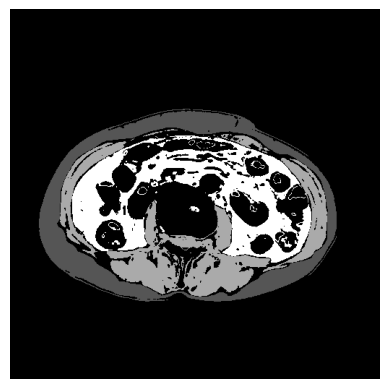

In [8]:
mask_sample = r'C:\Users\qwe14\0.code\sarcopenia\data_train_raw\#AsanNas\SarcopeniaCase1\20061220_ROI\Mask_40.png'
gt_mask = cv2.imread(mask_sample, cv2.IMREAD_GRAYSCALE)
plt.imshow(gt_mask, cmap = cm.gray)
plt.axis("off")
plt.show()

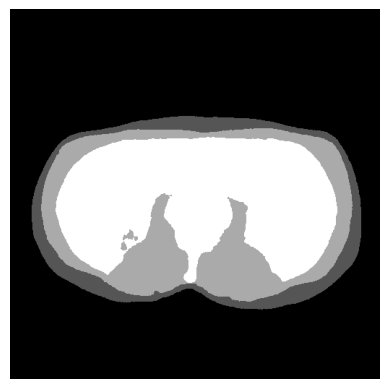

In [13]:
mask_sample = r"C:\Users\qwe14\0.code\sarcopenia\data_train_raw\output\result01\L3Data\SarcopeniaCase100_20071025_DCM\SarcopeniaCase100_20071025_DCM_00036.png"
gt_mask = cv2.imread(mask_sample, cv2.IMREAD_GRAYSCALE)
plt.imshow(gt_mask, cmap = cm.gray)
plt.axis("off")
plt.show()